# EDA India

## Overview
This notebook contains **Exploratory Data Analysis** and **Visualization** for the cases and vaccinations in India.

**Sections:**
1. [Data Ingestion](#Data_Ingestion)
2. [Summary Statistics](#Summary_Statistics)
3. [Data Cleaning](#3.-Data-Cleaning)
4. [Visualization](#Visualization)
5. [Correlation](#Correlation)
6. [Preprocessing](#Preprocessing)
7. [Conclusion](#Conclusion)

***
## Setup 

***NOTE***: Please install seaborn version >=  `0.11.0`. You could update your seaborn installation by running `pip install -U seaborn`

In [1]:
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.interpolate import CubicSpline

***
<a id='Data_Ingestion'></a>
## 1. Data Ingestion

### 1.1 Getting daily state-wise cases for India

In [2]:
cases = pd.read_csv("../raw_datasets/india_cases_12-10-2021.csv", index_col=0)
cases

,Province/State,Country_Region,Last Update,Confirmed,Deaths,Recovered,Date,Latitude,Longitude,FIPS,...,Province_State,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio
0,NaN,India,1/30/20 16:00,1.0,NaN,NaN,2020-01-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,India,1/31/2020 23:59,1.0,NaN,NaN,2020-01-31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,India,1/31/2020 8:15,1.0,0.0,0.0,2020-02-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,India,2020-02-02T06:03:08,2.0,0.0,0.0,2020-02-02,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,India,2020-02-03T21:43:02,3.0,0.0,0.0,2020-02-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18209,NaN,India,NaN,84285.0,816.0,NaN,2021-10-12,NaN,NaN,NaN,...,Tripura,2021-10-13 04:20:51,23.746783,91.743565,NaN,"Tripura, India",NaN,NaN,2021.322876,0.9681437978287952
18210,NaN,India,NaN,0.0,0.0,NaN,2021-10-12,NaN,NaN,NaN,...,Unknown,2021-10-13 04:20:51,NaN,NaN,NaN,"Unknown, India",NaN,NaN,NaN,NaN
18211,NaN,India,NaN,1709985.0,22896.0,NaN,2021-10-12,NaN,NaN,NaN,...,Uttar Pradesh,2021-10-13 04:20:51,26.925425,80.560982,NaN,"Uttar Pradesh, India",NaN,NaN,718.835300,1.3389591136764358
18212,NaN,India,NaN,343695.0,7397.0,NaN,2021-10-12,NaN,NaN,NaN,...,Uttarakhand,2021-10-13 04:20:51,30.156447,79.197608,NaN,"Uttarakhand, India",NaN,NaN,3054.833685,2.15219889727811


### 1.2  Getting daily state-wise vaccinations for India

In [3]:
vacc = pd.read_csv("../raw_datasets/india_vaccines_12-10-2021.csv", index_col=0)
vacc

,Updated On,State,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),...,AEFI,18-44 Years (Doses Administered),45-60 Years (Doses Administered),60+ Years (Doses Administered),18-44 Years (Individuals Vaccinated),45-60 Years (Individuals Vaccinated),60+ Years (Individuals Vaccinated),Male (Individuals Vaccinated),Female (Individuals Vaccinated),Transgender (Individuals Vaccinated)
0,2021-01-16,Andaman and Nicobar Islands,23.0,2.0,2.0,23.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,11.0,0.0
1,2021-01-16,Andhra Pradesh,4216.0,541.0,339.0,4216.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,857.0,3359.0,0.0
2,2021-01-16,Arunachal Pradesh,81.0,10.0,9.0,81.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,41.0,0.0
3,2021-01-16,Assam,401.0,79.0,64.0,401.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141.0,260.0,0.0
4,2021-01-16,Bihar,2967.0,222.0,219.0,2967.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,926.0,2041.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,2021-10-12,Telangana,28306599.0,3618596.0,3120.0,20393627.0,7912972.0,14370006.0,13931284.0,5309.0,...,426.0,15886178.0,7895479.0,4524942.0,NaN,NaN,NaN,NaN,NaN,NaN
9986,2021-10-12,Tripura,3994882.0,58166.0,115.0,2501022.0,1493860.0,2030599.0,1963681.0,602.0,...,78.0,2035501.0,1299565.0,659816.0,NaN,NaN,NaN,NaN,NaN,NaN
9987,2021-10-12,Uttar Pradesh,117159115.0,7765139.0,8111.0,91974814.0,25184301.0,62330170.0,54778681.0,50264.0,...,1851.0,68888424.0,30586541.0,17684150.0,NaN,NaN,NaN,NaN,NaN,NaN
9988,2021-10-12,Uttarakhand,10803381.0,286497.0,725.0,7421381.0,3382000.0,5560359.0,5238909.0,4113.0,...,494.0,6278209.0,2628031.0,1897141.0,NaN,NaN,NaN,NaN,NaN,NaN


***
<a id='Summary_Statistics'></a>
## 2. Summary statistics

In [4]:
# Summary statistics for cases in India
cases.describe()

,Province/State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Admin2,Lat,Long_,Active,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate
count,0.0,1.821400e+04,18212.000000,1.565900e+04,21.000000,21.000000,0.0,0.0,17672.000000,17672.000000,15609.000000,5436.000000,5380.000000,12168.000000
mean,NaN,4.139694e+05,5558.077147,3.103162e+05,20.825871,78.412671,NaN,NaN,23.102482,81.819393,21127.198475,359.635609,1.224933,2277.621568
std,NaN,8.215542e+05,13800.357492,6.322397e+05,0.206032,0.488279,NaN,NaN,6.549905,7.281782,56561.126646,473.089376,1.026203,2593.943658
min,NaN,0.000000e+00,0.000000,0.000000e+00,20.593700,78.000000,NaN,NaN,10.450898,71.590923,-250068.000000,0.000000,0.000000,0.000000
25%,NaN,1.206725e+04,126.000000,8.071500e+03,20.593700,78.000000,NaN,NaN,19.449759,76.405749,594.000000,47.313427,0.436467,737.143013
50%,NaN,9.703100e+04,1090.000000,5.850200e+04,21.000000,78.000000,NaN,NaN,23.746783,78.962880,3317.000000,179.756191,1.090552,1355.878688
75%,NaN,4.894270e+05,5400.250000,3.159220e+05,21.000000,78.962900,NaN,NaN,27.571671,87.979803,16076.000000,491.860789,1.663822,2894.399724
max,NaN,6.581677e+06,139621.000000,6.117560e+06,21.000000,78.962900,NaN,NaN,34.152600,96.384277,701614.000000,2840.977147,6.286311,16087.476137


In [5]:
# Summary statistics for vaccines in India
vacc.describe()

,Total Doses Administered,Sessions,Sites,First Dose Administered,Second Dose Administered,Male (Doses Administered),Female (Doses Administered),Transgender (Doses Administered),Covaxin (Doses Administered),CoviShield (Doses Administered),...,AEFI,18-44 Years (Doses Administered),45-60 Years (Doses Administered),60+ Years (Doses Administered),18-44 Years (Individuals Vaccinated),45-60 Years (Individuals Vaccinated),60+ Years (Individuals Vaccinated),Male (Individuals Vaccinated),Female (Individuals Vaccinated),Transgender (Individuals Vaccinated)
count,9.990000e+03,9.990000e+03,9.990000e+03,9.990000e+03,9.990000e+03,4.070000e+03,4.070000e+03,4070.000000,9.990000e+03,9.990000e+03,...,7.807000e+03,4.070000e+03,4.070000e+03,4.070000e+03,3.734000e+03,3.735000e+03,3.735000e+03,5.920000e+03,5.920000e+03,5920.000000
mean,1.643640e+07,8.638663e+05,2.918482e+03,1.273914e+07,3.697662e+06,1.697812e+07,1.524136e+07,6594.318673,1.909259e+06,1.448211e+07,...,1.522174e+03,1.548285e+07,9.895476e+06,6.848286e+06,1.395574e+06,2.915750e+06,2.626746e+06,2.411224e+06,2.135228e+06,668.468919
std,6.847879e+07,3.818360e+06,4.405568e+04,5.204448e+07,1.663048e+07,5.322001e+07,4.809581e+07,21617.512556,8.058335e+06,6.012707e+07,...,2.618977e+04,5.094356e+07,3.037111e+07,2.069650e+07,5.500752e+06,9.566440e+06,8.191239e+06,9.778427e+06,8.562723e+06,2897.771611
min,7.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,2.940000e+04,1.180000e+03,3.000000,0.000000e+00,7.000000e+00,...,0.000000e+00,2.662400e+04,1.681500e+04,9.994000e+03,1.059000e+03,1.136000e+03,5.580000e+02,0.000000e+00,2.000000e+00,0.000000
25%,2.469140e+05,8.175500e+03,6.800000e+01,1.952065e+05,3.701675e+04,5.620130e+05,4.658858e+05,189.000000,0.000000e+00,2.400495e+05,...,1.090000e+02,6.046735e+05,2.794588e+05,1.580100e+05,5.660150e+04,9.247600e+04,5.615200e+04,3.849650e+04,3.263750e+04,3.750000
50%,1.507410e+06,8.277050e+04,6.860000e+02,1.167937e+06,3.269805e+05,5.485104e+06,4.678409e+06,1878.000000,3.425950e+04,1.432618e+06,...,2.990000e+02,4.392032e+06,3.254274e+06,2.124637e+06,2.945885e+05,8.321420e+05,7.887420e+05,2.049135e+05,1.983260e+05,52.000000
75%,1.123974e+07,5.107835e+05,1.914750e+03,8.945087e+06,2.290837e+06,1.411891e+07,1.318208e+07,4837.500000,1.428831e+06,9.888671e+06,...,8.660000e+02,1.211466e+07,8.916640e+06,6.802536e+06,9.095950e+05,2.499081e+06,2.335726e+06,1.882112e+06,1.628501e+06,476.250000
max,9.638253e+08,1.032264e+08,4.333205e+06,6.900501e+08,2.737752e+08,4.984804e+08,4.616817e+08,215280.000000,1.108719e+08,8.484836e+08,...,2.290387e+06,5.313389e+08,2.625130e+08,1.665255e+08,9.224315e+07,9.096888e+07,6.731098e+07,1.349420e+08,1.156684e+08,46462.000000


<a id='missing_outliers'></a>
### 2.2 How many missing data and outliers? 

In [6]:
# Provides the number of missing values for cases in India
cases.isnull().sum()

Province/State         18214
Country_Region             0
Last Update            18162
Confirmed                  0
Deaths                     2
Recovered               2555
Date                       0
Latitude               18193
Longitude              18193
FIPS                   18214
Admin2                 18214
Province_State           132
Last_Update               52
Lat                      542
Long_                    542
Active                  2605
Combined_Key              52
Incidence_Rate         12778
Case-Fatality_Ratio    12834
Incident_Rate           6046
Case_Fatality_Ratio     6116
dtype: int64

In [7]:
cases.isnull().sum().sum()

153446

In [8]:
# Provides the number of missing values for vaccines in India
vacc.isnull().sum()

Updated On                                 0
State                                      0
Total Doses Administered                   0
Sessions                                   0
Sites                                      0
First Dose Administered                    0
Second Dose Administered                   0
Male (Doses Administered)               5920
Female (Doses Administered)             5920
Transgender (Doses Administered)        5920
Covaxin (Doses Administered)               0
CoviShield (Doses Administered)            0
Sputnik V (Doses Administered)          4626
AEFI                                    2183
18-44 Years (Doses Administered)        5920
45-60 Years (Doses Administered)        5920
60+ Years (Doses Administered)          5920
18-44 Years (Individuals Vaccinated)    6256
45-60 Years (Individuals Vaccinated)    6255
60+ Years (Individuals Vaccinated)      6255
Male (Individuals Vaccinated)           4070
Female (Individuals Vaccinated)         4070
Transgende

In [9]:
vacc.isnull().sum().sum()

73305

In [10]:
z_confirm = np.abs(stats.zscore(cases['Confirmed']))
print(z_confirm)

[0.50389821 0.50389821 0.50389821 ... 1.57756013 0.08554065 1.41655113]


In [11]:
z_adminstered = np.abs(stats.zscore(vacc['Total Doses Administered']))
print(z_adminstered)

[0.24003339 0.23997215 0.24003254 ... 1.47093376 0.08226338 0.71654862]


In [12]:
threshold = 3
print(np.where(z_confirm>3))

(array([11056, 11093, 11130, 11167, 11204, 11241, 11278, 11315, 11352,
       11389, 11426, 11463, 11500, 11537, 11574, 11611, 11648, 11685,
       11722, 11759, 11796, 11833, 11870, 11907, 11944, 11981, 12018,
       12055, 12092, 12129, 12166, 12203, 12240, 12277, 12314, 12351,
       12388, 12425, 12462, 12499, 12536, 12573, 12610, 12647, 12684,
       12721, 12758, 12795, 12832, 12869, 12906, 12943, 12980, 13017,
       13054, 13091, 13128, 13165, 13202, 13239, 13276, 13313, 13350,
       13387, 13424, 13461, 13498, 13535, 13572, 13609, 13646, 13683,
       13720, 13757, 13794, 13831, 13868, 13905, 13942, 13979, 14016,
       14053, 14090, 14127, 14164, 14201, 14234, 14238, 14271, 14275,
       14308, 14312, 14345, 14349, 14382, 14386, 14419, 14423, 14456,
       14460, 14493, 14497, 14530, 14534, 14567, 14571, 14604, 14608,
       14641, 14645, 14678, 14682, 14715, 14719, 14752, 14756, 14789,
       14793, 14826, 14830, 14863, 14867, 14900, 14904, 14936, 14937,
       14941, 14973

In [13]:
np.where(z_adminstered>3)

(array([5156, 5193, 5230, 5267, 5304, 5341, 5378, 5415, 5452, 5489, 5526,
        5563, 5600, 5637, 5674, 5711, 5748, 5785, 5822, 5859, 5896, 5933,
        5970, 6007, 6044, 6081, 6118, 6155, 6192, 6229, 6266, 6303, 6340,
        6377, 6414, 6451, 6488, 6525, 6562, 6599, 6636, 6673, 6710, 6747,
        6784, 6821, 6858, 6895, 6932, 6969, 7006, 7043, 7080, 7117, 7154,
        7191, 7228, 7265, 7302, 7339, 7376, 7413, 7450, 7487, 7524, 7561,
        7598, 7635, 7672, 7709, 7746, 7783, 7820, 7857, 7894, 7931, 7968,
        8005, 8042, 8079, 8116, 8153, 8190, 8227, 8264, 8301, 8338, 8375,
        8412, 8449, 8486, 8523, 8560, 8597, 8634, 8671, 8708, 8745, 8782,
        8819, 8856, 8893, 8930, 8967, 9004, 9041, 9078, 9115, 9152, 9189,
        9226, 9263, 9300, 9337, 9374, 9411, 9448, 9485, 9522, 9559, 9596,
        9633, 9670, 9707, 9744, 9781, 9818, 9855, 9892, 9929, 9966]),)

### 2.3 Any Inconsistent, Incomplete, duplicate or incorrect data

In [14]:
cases.duplicated().sum()

0

In [15]:
vacc.duplicated().sum()

0

In [16]:
incomplete_cases = cases.isnull().any(axis=1)
incomplete_cases

0        True
1        True
2        True
3        True
4        True
         ... 
18209    True
18210    True
18211    True
18212    True
18213    True
Length: 18214, dtype: bool

In [17]:
incomplete_vacc = vacc.isnull().any(axis=1)
incomplete_vacc

0       True
1       True
2       True
3       True
4       True
        ... 
9985    True
9986    True
9987    True
9988    True
9989    True
Length: 9990, dtype: bool

***
## 3. Data Cleaning

### 3.1 cases 

In [18]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18214 entries, 0 to 18213
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Province/State       0 non-null      float64
 1   Country_Region       18214 non-null  object 
 2   Last Update          52 non-null     object 
 3   Confirmed            18214 non-null  float64
 4   Deaths               18212 non-null  float64
 5   Recovered            15659 non-null  float64
 6   Date                 18214 non-null  object 
 7   Latitude             21 non-null     float64
 8   Longitude            21 non-null     float64
 9   FIPS                 0 non-null      float64
 10  Admin2               0 non-null      float64
 11  Province_State       18082 non-null  object 
 12  Last_Update          18162 non-null  object 
 13  Lat                  17672 non-null  float64
 14  Long_                17672 non-null  float64
 15  Active               15609 non-null 

In [19]:
# Provides the fraction of nulls in a particular column
cases.isnull().sum() / len(cases)

Province/State         1.000000
Country_Region         0.000000
Last Update            0.997145
Confirmed              0.000000
Deaths                 0.000110
Recovered              0.140277
Date                   0.000000
Latitude               0.998847
Longitude              0.998847
FIPS                   1.000000
Admin2                 1.000000
Province_State         0.007247
Last_Update            0.002855
Lat                    0.029757
Long_                  0.029757
Active                 0.143022
Combined_Key           0.002855
Incidence_Rate         0.701548
Case-Fatality_Ratio    0.704623
Incident_Rate          0.331942
Case_Fatality_Ratio    0.335786
dtype: float64

Above we can see that `Province/State`, `FIPS`, `Admin2` have a Null Ratio of `1.00` 
So we can go ahead and drop these columns from our dataframe

In [20]:
#Dropping the columns with 100% null values
cases.drop(['Province/State', 'FIPS', 'Admin2'], inplace = True, axis = 1)

`Last Update`, `Latitude` and `Longitude` have very few non-null values. This is because they are repeated columns corresponding `Last_Update`, `Lat` and `Long_` which have a low Null Ratio. Due to this we have decided to merge the values from the first set *(High Null Ratio)* to its corresponding second set column *(Low Null Ratio)*

In [21]:
# Number of nulls in second set columns before combining
print(cases['Last_Update'].isnull().sum())
print(cases['Lat'].isnull().sum())
print(cases['Long_'].isnull().sum())

52
542
542


In [22]:
# For Last Update and Last_Update
cases['Last_Update'] = cases['Last_Update'].combine_first(cases['Last Update'])

# For Latitude and Lat
cases['Lat'] = cases['Lat'].combine_first(cases['Latitude'])

# For Longitude and Long
cases['Long_'] = cases['Long_'].combine_first(cases['Longitude'])

In [23]:
# Number of nulls in second set columns after combining
print(cases['Last_Update'].isnull().sum())
print(cases['Lat'].isnull().sum())
print(cases['Long_'].isnull().sum())

0
521
521


Now that `Last Update`, `Latitude` and `Longitude` have been combined into their corresponding `Last_Update`, `Lat` and `Long_` columns, the first set is now redundant. So we can drop them

In [24]:
cases.drop(['Last Update', 'Latitude', 'Longitude'], inplace=True, axis = 1)

Similary by observation `Incidence_Rate` , `Incident_Rate` and `Case-Fatality_Ratio` , `Case_Fatality_Ratio` are pairs of redundant columns. So we need to combine and drop one column from each pair

In [25]:
# For Incidence_Rate and Incident_Rate
cases['Incident_Rate'] = cases['Incident_Rate'].combine_first(cases['Incidence_Rate'])

# For Case-Fatality_Ratio and Case_Fatality_Ratio
cases['Case_Fatality_Ratio'] = cases['Case_Fatality_Ratio'].combine_first(cases['Case-Fatality_Ratio'])

#Dropping the redundant columns after combining
cases.drop(['Incidence_Rate', 'Case-Fatality_Ratio'], inplace=True, axis = 1)

In [26]:
# Info after cleaning cases
cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18214 entries, 0 to 18213
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country_Region       18214 non-null  object 
 1   Confirmed            18214 non-null  float64
 2   Deaths               18212 non-null  float64
 3   Recovered            15659 non-null  float64
 4   Date                 18214 non-null  object 
 5   Province_State       18082 non-null  object 
 6   Last_Update          18214 non-null  object 
 7   Lat                  17693 non-null  float64
 8   Long_                17693 non-null  float64
 9   Active               15609 non-null  float64
 10  Combined_Key         18162 non-null  object 
 11  Incident_Rate        17604 non-null  float64
 12  Case_Fatality_Ratio  17478 non-null  object 
dtypes: float64(7), object(6)
memory usage: 1.9+ MB


In [27]:
cases.to_csv('../cleaned_datasets/india/statewise_cases_india.csv')

### 3.2 vacc

In [28]:
vacc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 0 to 9989
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Updated On                            9990 non-null   object 
 1   State                                 9990 non-null   object 
 2   Total Doses Administered              9990 non-null   float64
 3   Sessions                              9990 non-null   float64
 4   Sites                                 9990 non-null   float64
 5   First Dose Administered               9990 non-null   float64
 6   Second Dose Administered              9990 non-null   float64
 7   Male (Doses Administered)             4070 non-null   float64
 8   Female (Doses Administered)           4070 non-null   float64
 9   Transgender (Doses Administered)      4070 non-null   float64
 10  Covaxin (Doses Administered)          9990 non-null   float64
 11  CoviShield (Doses

In [29]:
# Provides the fraction of nulls in a particular column
vacc.isnull().sum() / len(vacc)

Updated On                              0.000000
State                                   0.000000
Total Doses Administered                0.000000
Sessions                                0.000000
Sites                                   0.000000
First Dose Administered                 0.000000
Second Dose Administered                0.000000
Male (Doses Administered)               0.592593
Female (Doses Administered)             0.592593
Transgender (Doses Administered)        0.592593
Covaxin (Doses Administered)            0.000000
CoviShield (Doses Administered)         0.000000
Sputnik V (Doses Administered)          0.463063
AEFI                                    0.218519
18-44 Years (Doses Administered)        0.592593
45-60 Years (Doses Administered)        0.592593
60+ Years (Doses Administered)          0.592593
18-44 Years (Individuals Vaccinated)    0.626226
45-60 Years (Individuals Vaccinated)    0.626126
60+ Years (Individuals Vaccinated)      0.626126
Male (Individuals Va

In [30]:
vacc.to_csv('../cleaned_datasets/india/vacc_india.csv')

There is no column with a significant majority of Nulls. **All columns can be left as is**

***
<a id='Visualization'></a>
## 4. Visualization

### 4.1 Histograms

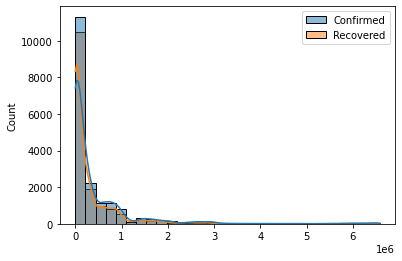

In [31]:
histogram_filter_cases = cases[['Confirmed', 'Recovered']]
sns.histplot(data=histogram_filter_cases, bins=30, kde=True)

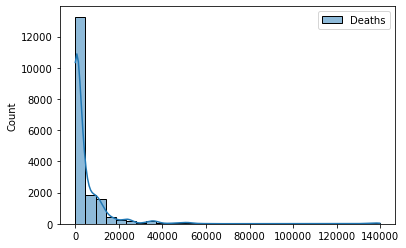

In [32]:
histogram_filter_cases = cases[['Deaths']]
sns.histplot(data=histogram_filter_cases, bins=30, kde=True)

### 4.2 Bar Charts

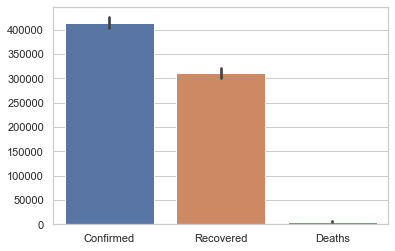

In [33]:
barchart_filter_cases = cases[['Confirmed', 'Recovered','Deaths']]
sns.set_theme(style='whitegrid')
sns.barplot(data=barchart_filter_cases)

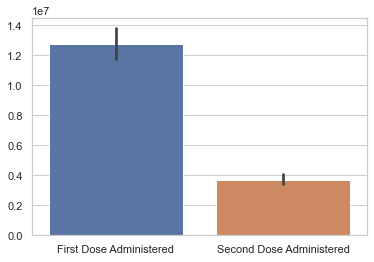

In [34]:
barchart_filter_vacc = vacc[['First Dose Administered', 'Second Dose Administered']]
sns.set_theme(style='whitegrid')
sns.barplot(data=barchart_filter_vacc)

[[Text(0, 0, '18-44 Years'),
  Text(0, 0, '45-60 Years'),
  Text(0, 0, '60+ Years')]]

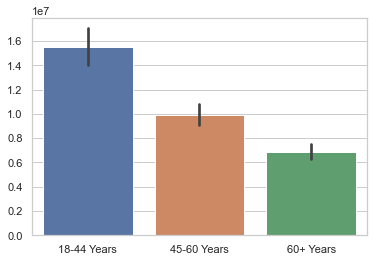

In [35]:
barchart_filter_vacc = vacc[['18-44 Years (Doses Administered)', '45-60 Years (Doses Administered)', '60+ Years (Doses Administered)']]
sns.set_theme(style='whitegrid')
b = sns.barplot(data=barchart_filter_vacc)
b.set(xticklabels=['18-44 Years','45-60 Years','60+ Years'])

### 4.3 Line Plots 

#### Getting Time Series Data
Before obtaining Line Plots we first extract the time series data. This is done by
- Grouping by Date
- Aggregating Confirmed, Deaths and Recovered by Sum

In [36]:
# Cumulative Time Series (Add on to previous date's cases)
cum_timeseries = cases.groupby(['Date']).agg(Confirmed = ('Confirmed', 'sum'), Deaths = ('Deaths', 'sum'), Recovered = ('Recovered', 'sum'), Active = ('Active', 'sum'))

# Delta Time series (Cases on a particular day)
delta_timeseries = cum_timeseries.diff()

In [37]:
cum_timeseries.to_csv('../cleaned_datasets/india/cum_cases_india.csv')
delta_timeseries.to_csv('../cleaned_datasets/india/daily_cases_india.csv')

#### Plots

**1. Confirmed Cases**

1.1 Cumulative confirmed cases

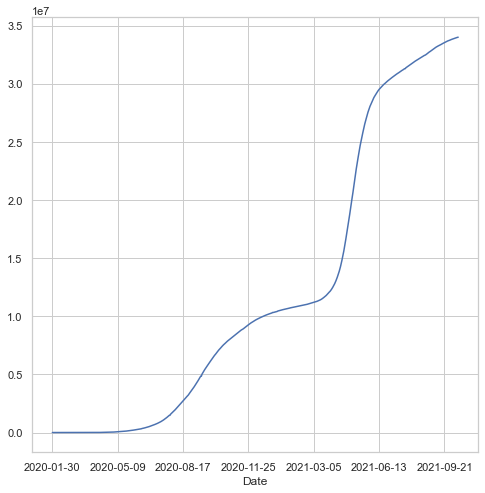

In [38]:
cum_timeseries.Confirmed.plot(figsize=(8, 8))

1.2 Daily confirmed cases

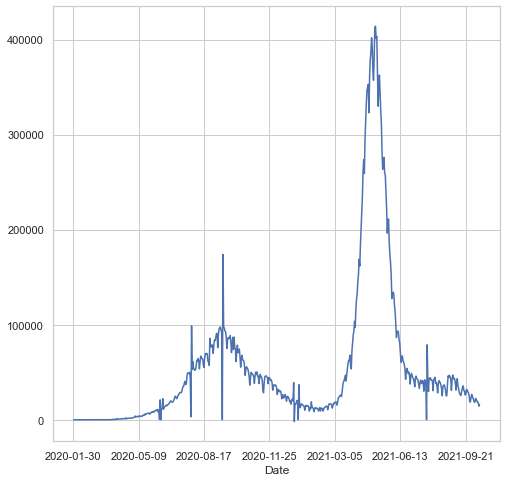

In [39]:
delta_timeseries.Confirmed.plot(figsize=(8, 8))

**2. Deaths**

2.1 Cumulative Deaths

In [ ]:
cum_timeseries.Deaths.plot(figsize=(8, 8))

2.1 Cumulative Deaths

In [ ]:
delta_timeseries.Deaths.plot(figsize=(8, 8))

**3. Recovered**    
***NOTE:*** Recovered data is only available upto `2021-08-04` and is missing after that date. So the plot has been done only considering dates before `2021-08-05`, after cleaning the data

In [ ]:
# Trimming off NaNs in Recovered Column after 2021-08-04 and then getting aggregate count by date
trim_df = cases['Date'] < '2021-08-05'
trim_cases = cases.loc[trim_df] 
rec_cum_timeseries = trim_cases.groupby(['Date']).agg(Recovered = ('Recovered', 'sum'))

In [ ]:
rec_cum_timeseries.Recovered.plot(figsize=(8, 8))

In [ ]:
rec_delta_timeseries = rec_cum_timeseries.diff()
rec_delta_timeseries.Recovered.plot(figsize=(8, 8))

In [45]:
cum_vacc = vacc.groupby(['Updated On']).agg(Total_Doses = ('Total Doses Administered', 'sum'), First_Dose = ('First Dose Administered', 'sum'), Second_Dose = ('Second Dose Administered', 'sum'))
delta_vacc = cum_vacc.diff()

In [47]:
cum_vacc.to_csv('../cleaned_datasets/india/cum_vacc_india.csv')
delta_vacc.to_csv('../cleaned_datasets/india/daily_vacc_india.csv')

### 4.4 PCA

#### 4.1 Convert categorical columns to numerical

***
<a id='Correlation'></a>

## 5. Correlation

- Find the correlation matrix for `cases` and `vacc` to see if any attributes are strongly correlated (we take a threshold of 80%)
- We see if the correlation is meaningful, or indicative of excessive attributes

### 5.1 Correlation for `cases`

In [ ]:
# Correlation matrix
corr_cases = cases.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_cases, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr_cases, mask=mask, center=0, square=True, annot=True)

### Observations - `cases`

1. We observe that `Deaths` and `Confirmed` are stronly positively correlated with a correlation coefficient of `0.91`
2. We also observe that `Deaths` and `Recovered` are stronly positively correlated with a correlation coefficient of `0.92`
3. Finally, we observe that `Recovered` and `Confirmed` are stronly positively correlated with a correlation coefficient of `1`
4. There is no strong negative correlation between any of the attributes

These observations are consistent with the expectation that as daily case numbers rise, recovered numbers and death counts rise

### 5.2 Correlation for `vacc`

In [ ]:
# Correlation matrix
corr_vacc = vacc.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_vacc, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(corr_vacc, mask=mask, center=0, square=True, annot=True)

### Observations - `vacc`

Almost all the attributes are strongly positively correlated. This makes intuitive sense as many of the attributes are subsets of the total doses administered in a single day.

***
<a id='Preprocessing'></a>
## 6. Preprocessing

1. Continuum cubic spline curve interpolation

### 6.1  Contituum cubic spline curve interpolation on 7-day average

- The 7-day average for total daily number of cases is calculated
- The values are then interpolated using a cubic spline curve
- This is done to create a continuous function out of discrete points
- The derivatives of the CS curve are plotted for smoothed out `Confirmed`, `Deaths` and `Recovered`

#### 6.1.1 Seven-day average of daily confirmed cases

In [ ]:
# Find 7 day average of confirmed cases from delta_timeseries

confirmed_7_day = delta_timeseries.Confirmed.rolling(7, min_periods=1).mean()
confirmed_7_day = confirmed_7_day.reset_index()

confirmed_7_day

#### Lineplot of smoothed (7-day-average) confirmed cases

In [ ]:
confirmed_7_day.plot(x='Date', figsize=(8, 8))

#### Cubic Spline Curve Interpolation

In [ ]:
confirmed_7_day = confirmed_7_day.loc[confirmed_7_day['Confirmed'].notnull()]
confirmed_7_day['Date_delta'] = (pd.to_datetime(confirmed_7_day['Date']) - pd.to_datetime(confirmed_7_day['Date']).min())  / np.timedelta64(1,'D')

cs_confirmed = CubicSpline(confirmed_7_day.Date_delta, confirmed_7_day.Confirmed)

#### Plot of DC (Daily Confirmed)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(confirmed_7_day['Date_delta'], cs_confirmed(confirmed_7_day['Date_delta']), label='Daily cases (DC)')

#### Plot of DC' (First derivative of Daily Confirmed)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(confirmed_7_day['Date_delta'], cs_confirmed(confirmed_7_day['Date_delta'], 1), label='First derivative of DC')

#### 6.1.2 Seven-day average of daily deaths

In [ ]:
# Find 7 day average of deaths from delta_timeseries

deaths_7_day = delta_timeseries.Deaths.rolling(7, min_periods=1).mean()
deaths_7_day = deaths_7_day.reset_index()

deaths_7_day

#### Lineplot of smoothed (7-day-average) deaths

In [ ]:
deaths_7_day.plot(x='Date', figsize=(8, 8))

#### Cubic Spline Curve Interpolation

In [ ]:
deaths_7_day = deaths_7_day.loc[deaths_7_day['Deaths'].notnull()]
deaths_7_day['Date_delta'] = (pd.to_datetime(deaths_7_day['Date']) - pd.to_datetime(deaths_7_day['Date']).min())  / np.timedelta64(1,'D')

cs_deaths = CubicSpline(deaths_7_day.Date_delta, deaths_7_day.Deaths)

#### Plot of DD (Daily Deaths)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(deaths_7_day['Date_delta'], cs_deaths(deaths_7_day['Date_delta']), label='Daily Deaths (DD)')

#### Plot of DD' (First derivative of DD)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(deaths_7_day['Date_delta'], cs_deaths(deaths_7_day['Date_delta'], 1), label='First derivative of DD')

#### 6.1.3 Seven-day average of daily recoveries

In [ ]:
# Find 7 day average of recovered cases from delta_timeseries

rec_7_day = rec_delta_timeseries.Recovered.rolling(7, min_periods=1).mean()
rec_7_day = rec_7_day.reset_index()

rec_7_day

#### Lineplot of smoothed (7-day-average) recoveries

In [ ]:
rec_7_day.plot(x='Date', figsize=(8, 8))

#### Cubic Spline Curve Interpolation

In [ ]:
rec_7_day = rec_7_day.loc[rec_7_day['Recovered'].notnull()]
rec_7_day['Date_delta'] = (pd.to_datetime(rec_7_day['Date']) - pd.to_datetime(rec_7_day['Date']).min())  / np.timedelta64(1,'D')

cs_rec = CubicSpline(rec_7_day.Date_delta, rec_7_day.Recovered)

#### Plot of DR (Daily Recoveries)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(rec_7_day['Date_delta'], cs_rec(rec_7_day['Date_delta']), label='Daily Recoveries (DR)')

#### Plot of DR' (First derivative of DR)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(rec_7_day['Date_delta'], cs_rec(rec_7_day['Date_delta'], 1), label='First derivative of DR')

***
<a id='Conclusion'></a>
## 7. Conclusion 

- How many rows and attributes?
    - Size of cases in india is: `(18214, 22)`.
    - Size of vaccinations in india is: `(9990, 24)`.
- How many missing data and outliers?
    - `153446` missing elements for cases.
    - `73305` missing elements for vaccines.
- Any inconsistent, incomplete, duplicate or incorrect data?
    - All values in cases and vaccines are unique.
    - Cases in india contains `18214` incomplete rows.
    - Vaccinations in india contains `9990` incomplete rows.
- Are the variables correlated to each other?
    - The `Recovered`, `Confirmed` and `Deaths` columns in `cases` are strongly positively correlated.
    - Almost all attributes in `vacc` are strongly positively correlated.

- Are any of the preprocessing techniques needed: rolling average, continuum cubic spline curve, dimensionality reduction, range transformation, standardization, etc.?
    - Using the 7-day rolling average of the daily `Confirmed`, `Deaths` and `Recovered` shows a smoother plot with less noise.
    - Calculating the continuum cubic spline curve allows us to differentiate the function and find the instantaneous slope.

- Does PCA help visualize the data? Do we get any insights from histograms/bar charts/line plots, etc.?